In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
topics = 5

In [3]:
df = pd.read_fwf('data/data.txt')


In [4]:
stop_words = stopwords.words('portuguese')


In [5]:
def split_pdf(string): 
    li = list(string.split(" ")) 
    return li

In [6]:
def first_clear(data):
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    #remove links and mark
    data = [re.sub('(https:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(http:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(www.:\S+)|(@)|(¿)', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # remove spaces in begining and end
    data = [re.sub(' +', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    return data

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [8]:
def bi_tri_gram(data):
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [11]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [12]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
def filter_pos_tagging(data, pos):
    lista = []
    for token in data:
        for p in pos:
            if (token.pos_ == p):
                lista.append(token.text)
#                 print(token.text)

    
    return [[el] for el in lista]

In [15]:
nlp = spacy.load('pt_core_news_sm')
mallet_path = 'mallet-2.0.8/bin/mallet' 
nlp.max_length = 20000000

texto = str(df.values.tolist())
# print(texto)
data = split_pdf(texto)
# print(data)

data = first_clear(data)
# print(data)

data = list(sent_to_words(data))

# Remove Stop Words
data_words_nostops = remove_stopwords(data)

# print(data_words_nostops)
aggregate = {}
list_pos = [['NOUN'], ['ADJ'], ['NOUN', 'ADJ']]

for i in range(0, len(list_pos)):
    l = []
    data_filtered = filter_pos_tagging(nlp(str(data_words_nostops)), list_pos[i] )
    bigram_mod, trigram_mod = bi_tri_gram(data_filtered)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_filtered)
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    print(data_lemmatized)
    id2word = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=topics,random_state=100,\
                                            update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topics, id2word=id2word)

    l.append(list_pos[i])
    l.append(data_lemmatized)
    l.append(id2word)
    l.append(corpus)
    l.append(lda_model)
    l.append(ldamallet)
    aggregate[i] = l


[['doutrinar'], ['fato'], ['motivador'], ['reparacao'], ['danar'], ['natureza'], ['ofenso'], ['personalidade'], ['sao'], ['fisicos'], ['morar'], ['pessoa'], ['indenizado'], ['danar'], ['relevancia'], ['razao'], ['inadimplemento'], ['partir'], ['vidar'], ['sociedade'], ['formar'], ['sao'], ['assediar'], ['ter'], ['conduta'], ['causar'], ['constrangimento'], ['pessoa'], ['assediar'], ['assediar'], ['assediar'], ['conduta'], ['abusivo'], ['natureza'], ['dignidade'], ['individuar'], ['formar'], ['efeito'], ['exclusao'], ['ambientar'], ['convivio'], ['assediar'], ['direito'], ['trabalhar'], ['abusar'], ['direito'], ['partir'], ['empregador'], ['abusar'], ['atitude'], ['partir'], ['empreendimento'], ['sentir'], ['imagem'], ['trabalhador'], ['humilhar'], ['submeter'], ['conduta'], ['vexatorias'], ['usar'], ['poder'], ['disciplinar'], ['veracidade'], ['inicial'], ['confissao'], ['ficta'], ['revelir'], ['partir'], ['autor'], ['conduta'], ['sr'], ['brunir'], ['pretensao'], ['doutrinar'], ['juris

# Tópicos apenas levando em conta os Substantivos

In [16]:
pprint(aggregate[0][4].print_topics())
doc_lda = aggregate[0][4][aggregate[0][3]]

[(0,
  '0.074*"tst" + 0.074*"importancia" + 0.074*"julgar" + 0.074*"titulo" + '
  '0.074*"real" + 0.074*"pedagogica" + 0.017*"relevancia" + 0.017*"quantum" + '
  '0.017*"atitude" + 0.017*"constrangimento"'),
 (1,
  '0.094*"empregador" + 0.094*"gravidade" + 0.072*"assediar" + 0.032*"direito" '
  '+ 0.032*"ofenso" + 0.032*"pessoa" + 0.019*"reiteracao" + 0.019*"revelir" + '
  '0.019*"sociedade" + 0.019*"veracidade"'),
 (2,
  '0.132*"conduta" + 0.108*"danar" + 0.084*"causar" + 0.053*"partir" + '
  '0.029*"efeito" + 0.029*"natureza" + 0.017*"motivador" + 0.017*"brunir" + '
  '0.017*"morar" + 0.017*"ilicito"'),
 (3,
  '0.111*"re" + 0.038*"doutrinar" + 0.038*"abusar" + 0.038*"formar" + '
  '0.038*"abusivo" + 0.022*"fato" + 0.022*"vidar" + 0.022*"humilhar" + '
  '0.022*"lado" + 0.022*"sentir"'),
 (4,
  '0.105*"autor" + 0.050*"atar" + 0.050*"quantiar" + 0.050*"finalidade" + '
  '0.050*"relacao" + 0.050*"enriquecimento" + 0.050*"pedir" + '
  '0.050*"pagamento" + 0.050*"exame" + 0.050*"corrente"'

In [17]:
print('\nPerplexity: ', aggregate[0][4].log_perplexity(aggregate[0][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[0][4], texts=aggregate[0][1], dictionary=aggregate[0][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.3577414963245396

Coherence Score:  0.8490929851613178


In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[0][4], aggregate[0][3], aggregate[0][2])
vis

/opt/anaconda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.206959 -0.005001       1        1  24.670803
2      0.073481 -0.135082       2        1  23.290642
1      0.042677  0.009317       3        1  20.397144
0      0.066078  0.127202       4        1  15.836881
3      0.024723  0.003565       5        1  15.804531, topic_info=   Category      Freq       Term     Total  loglift  logprob
22  Default  4.000000    conduta  4.000000  30.0000  30.0000
63  Default  2.000000         re  2.000000  29.0000  29.0000
4   Default  3.000000      danar  3.000000  28.0000  28.0000
52  Default  3.000000      autor  3.000000  27.0000  27.0000
61  Default  2.000000  gravidade  2.000000  26.0000  26.0000
..      ...       ...        ...       ...      ...      ...
90   Topic5  0.122558  monetaria  2.026445  -0.9606  -5.0826
89   Topic5  0.122558   corrente  2.026445  -0.9606  -5.0826
78   Topic5  0.122558   quantiar  2.026445  -0.9606  -5.0826
86   Topic5  0.122558  pagamento  2.026445  -0.9606  -5.0826
84   Topic5  0.122558      pedir  2.026445  -0.9606  -5.0826

[226 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
34        5  0.821696          abusar
25        5  0.821694         abusivo
20        3  0.869300        assediar
77        1  0.986950            atar
52        1  0.806142           autor
23        2  0.689258          causar
22        2  0.929389         conduta
89        1  0.986950        corrente
4         2  0.832686           danar
91        1  0.986950         decisao
32        3  0.785409         direito
0         5  0.821696       doutrinar
28        2  0.775591          efeito
35        3  0.702133      empregador
82        1  0.986950  enriquecimento
76        1  0.986950           exame
79        1  0.986950      finalidade
19        5  0.821700          formar
61        3  0.702133       gravidade
87        4  0.510346     importancia
83        4  0.510346          julgar
90        1  0.986950       monetaria
5         2  0.775595        natureza
6         3  0.785409          ofenso
86        1  0.986950       pagamento
16        2  1.004795          partir
80        4  0.510346      pedagogica
84        1  0.986950           pedir
11        3  0.785414          pessoa
59        1  0.907454         propria
78        1  0.986950        quantiar
63        5  0.751067              re
88        4  0.510346            real
81        1  0.986950         relacao
8         1  0.907454             sao
85        4  0.510346          titulo
92        4  0.510346             tst, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 1, 4])

In [19]:
pprint(aggregate[0][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[0][5], texts=aggregate[0][1], dictionary=aggregate[0][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.083*"sao" + 0.042*"constrangimento" + 0.042*"vidar" + 0.042*"finalidade" '
  '+ 0.042*"assediar" + 0.042*"dificil" + 0.042*"usar" + 0.042*"exame" + '
  '0.042*"convivio" + 0.042*"imagem"'),
 (1,
  '0.160*"assediar" + 0.080*"pessoa" + 0.080*"propria" + 0.040*"tst" + '
  '0.040*"necessidade" + 0.040*"ter" + 0.040*"causar" + 0.040*"quantiar" + '
  '0.040*"confissao" + 0.040*"atitude"'),
 (2,
  '0.115*"partir" + 0.077*"abusar" + 0.038*"ofensivo" + 0.038*"sociedade" + '
  '0.038*"revelir" + 0.038*"indenizado" + 0.038*"dignidade" + '
  '0.038*"trabalhador" + 0.038*"julgar" + 0.038*"empregador"'),
 (3,
  '0.261*"conduta" + 0.043*"inicial" + 0.043*"efeito" + 0.043*"empregador" + '
  '0.043*"submeter" + 0.043*"vexatorias" + 0.043*"fato" + 0.043*"partir" + '
  '0.043*"fitar" + 0.043*"relacao"'),
 (4,
  '0.160*"danar" + 0.080*"direito" + 0.080*"autor" + 0.040*"doutrinar" + '
  '0.040*"ambientar" + 0.040*"atar" + 0.040*"causar" + 0.040*"reiteracao" + '
  '0.040*"pedagogica" + 0.040*"efei

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[0][2], corpus=aggregate[0][3], texts=aggregate[0][1], start=2, limit=40, step=6)


/opt/anaconda/lib/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:379: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


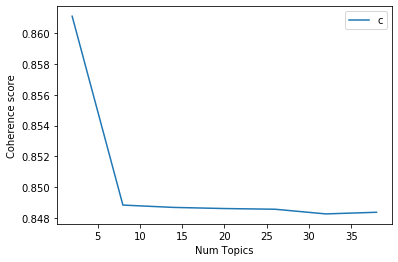

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos apenas levando em conta os Adjetivos


In [22]:
pprint(aggregate[1][4].print_topics())
doc_lda = aggregate[1][4][aggregate[1][3]]

[(0,
  '0.125*"procedente" + 0.125*"psiquica" + 0.125*"atento" + 0.125*"economica" '
  '+ 0.125*"reparaveis" + 0.125*"sexual" + 0.022*"moral" + 0.021*"mear" + '
  '0.021*"mero" + 0.021*"psicologica"'),
 (1,
  '0.524*"moral" + 0.141*"mear" + 0.077*"mero" + 0.077*"psicologica" + '
  '0.013*"sexual" + 0.013*"economica" + 0.013*"procedente" + 0.013*"atento" + '
  '0.013*"reparaveis" + 0.013*"psiquica"'),
 (2,
  '0.214*"psicologico" + 0.214*"compensatoria" + 0.036*"moral" + 0.036*"mear" '
  '+ 0.036*"reparaveis" + 0.036*"psicologica" + 0.036*"sexual" + 0.036*"bom" + '
  '0.036*"ipsa" + 0.036*"procedente"'),
 (3,
  '0.214*"decorrente" + 0.214*"presentar" + 0.036*"moral" + 0.036*"mear" + '
  '0.036*"economica" + 0.036*"sexual" + 0.036*"ipsa" + 0.036*"passivar" + '
  '0.036*"psicologica" + 0.036*"reparaveis"'),
 (4,
  '0.157*"semelhante" + 0.157*"bom" + 0.157*"ipsa" + 0.157*"passivar" + '
  '0.030*"moral" + 0.026*"mear" + 0.026*"psicologica" + 0.026*"psiquica" + '
  '0.026*"atento" + 0.026*"se

In [23]:
print('\nPerplexity: ', aggregate[1][4].log_perplexity(aggregate[1][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[1][4], texts=aggregate[1][1], dictionary=aggregate[1][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.0275606874089975

Coherence Score:  0.8571460679804936


In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[1][4], aggregate[1][3], aggregate[1][2])
vis

/opt/anaconda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.235931 -0.014140       1        1  40.719013
0     -0.096573 -0.110108       2        1  22.072203
4     -0.060950  0.111583       3        1  16.498016
2     -0.039180  0.006331       4        1  10.363455
3     -0.039227  0.006334       5        1  10.347320, topic_info=   Category      Freq           Term     Total  loglift  logprob
1   Default  5.000000          moral  5.000000  18.0000  18.0000
10  Default  1.000000     decorrente  1.000000  17.0000  17.0000
17  Default  1.000000      presentar  1.000000  16.0000  16.0000
4   Default  1.000000    psicologico  1.000000  15.0000  15.0000
14  Default  1.000000  compensatoria  1.000000  14.0000  14.0000
..      ...       ...            ...       ...      ...      ...
15   Topic5  0.096104     procedente  1.157620  -0.2203  -3.3320
6    Topic5  0.096113    psicologica  1.240438  -0.2893  -3.3319
2    Topic5  0.096110           mero  1.240444  -0.2893  -3.3319
9    Topic5  0.096125           mear  1.920643  -0.7263  -3.3318
1    Topic5  0.096279          moral  5.997757  -1.8634  -3.3302

[108 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
7         2  0.863843         atento
0         3  0.890728            bom
14        4  0.960209  compensatoria
10        5  0.960882     decorrente
13        2  0.863843      economica
11        3  0.890730           ipsa
9         1  0.520659           mear
2         1  0.806163           mero
1         1  1.000374          moral
16        3  0.890728       passivar
17        5  0.960876      presentar
15        2  0.863841     procedente
6         1  0.806167    psicologica
4         4  0.960211    psicologico
8         2  0.863843       psiquica
3         2  0.863845     reparaveis
12        3  0.890726     semelhante
5         2  0.863844         sexual, R=18, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 4])

In [25]:
pprint(aggregate[1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[1][5], texts=aggregate[1][1], dictionary=aggregate[1][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  'nan*"decorrente" + nan*"psiquica" + nan*"passivar" + nan*"procedente" + '
  'nan*"compensatoria" + nan*"economica" + nan*"semelhante" + nan*"ipsa" + '
  'nan*"bom" + nan*"mear"'),
 (1,
  '0.250*"procedente" + 0.250*"psiquica" + 0.250*"bom" + 0.250*"reparaveis" + '
  '0.000*"semelhante" + 0.000*"decorrente" + 0.000*"passivar" + 0.000*"mero" + '
  '0.000*"compensatoria" + 0.000*"economica"'),
 (2,
  '0.167*"ipsa" + 0.167*"mero" + 0.167*"passivar" + 0.167*"sexual" + '
  '0.167*"atento" + 0.167*"economica" + 0.000*"psiquica" + 0.000*"procedente" '
  '+ 0.000*"compensatoria" + 0.000*"semelhante"'),
 (3,
  '0.700*"moral" + 0.100*"decorrente" + 0.100*"psicologica" + '
  '0.100*"semelhante" + 0.000*"psiquica" + 0.000*"passivar" + '
  '0.000*"procedente" + 0.000*"compensatoria" + 0.000*"economica" + '
  '0.000*"ipsa"'),
 (4,
  '0.333*"mear" + 0.167*"presentar" + 0.167*"psicologico" + '
  '0.167*"compensatoria" + 0.167*"moral" + 0.000*"ipsa" + 0.000*"passivar" + '
  '0.000*"procedente" +

/opt/anaconda/lib/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:448: RuntimeWarning: invalid value encountered in true_divide
  topic = topic / topic.sum()  # normalize to probability dist
/opt/anaconda/lib/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:379: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]



Coherence Score:  0.8571460679804938


In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[1][2], corpus=aggregate[1][3], texts=aggregate[1][1], start=2, limit=40, step=6)


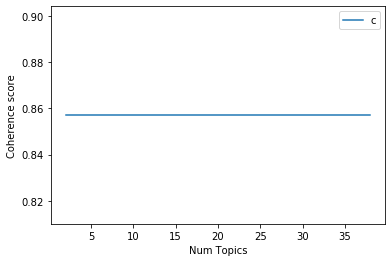

In [27]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos levando em conta os Adjetivos e Substantivos


In [28]:
pprint(aggregate[2][4].print_topics())
doc_lda = aggregate[2][4][aggregate[2][3]]

[(0,
  '0.072*"assediar" + 0.056*"ofenso" + 0.056*"gravidade" + 0.056*"causar" + '
  '0.042*"reiteracao" + 0.042*"monetaria" + 0.042*"economica" + 0.032*"mear" + '
  '0.032*"pessoa" + 0.032*"natureza"'),
 (1,
  '0.062*"efeito" + 0.062*"empregador" + 0.062*"abusivo" + 0.047*"relacao" + '
  '0.035*"abusar" + 0.020*"veracidade" + 0.020*"indenizado" + 0.020*"fato" + '
  '0.020*"atento" + 0.020*"psicologico"'),
 (2,
  '0.159*"moral" + 0.109*"conduta" + 0.092*"autor" + 0.031*"doutrinar" + '
  '0.018*"inicial" + 0.018*"reparacao" + 0.018*"imagem" + 0.018*"disciplinar" '
  '+ 0.018*"individuar" + 0.018*"poder"'),
 (3,
  '0.040*"re" + 0.021*"dificil" + 0.021*"finalidade" + 0.021*"quantiar" + '
  '0.021*"tst" + 0.021*"ipsa" + 0.021*"atar" + 0.021*"exame" + '
  '0.021*"semelhante" + 0.021*"lado"'),
 (4,
  '0.104*"danar" + 0.074*"partir" + 0.040*"formar" + 0.040*"direito" + '
  '0.023*"relevancia" + 0.023*"sentir" + 0.023*"ambientar" + 0.023*"submeter" '
  '+ 0.023*"dignidade" + 0.023*"reparaveis"

In [29]:
print('\nPerplexity: ', aggregate[2][4].log_perplexity(aggregate[2][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[2][4], texts=aggregate[2][1], dictionary=aggregate[2][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.283402011785286

Coherence Score:  0.8484589325168093


In [30]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[2][4], aggregate[2][3], aggregate[2][2])
vis

/opt/anaconda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.171176 -0.027631       1        1  36.297882
2     -0.088921 -0.129704       2        1  18.412027
0     -0.054421  0.111671       3        1  17.143190
1     -0.022955  0.027859       4        1  14.830007
4     -0.004878  0.017806       5        1  13.316891, topic_info=    Category      Freq            Term     Total  loglift  logprob
6    Default  4.000000           moral  4.000000  30.0000  30.0000
26   Default  3.000000         conduta  3.000000  29.0000  29.0000
5    Default  2.000000           danar  2.000000  28.0000  28.0000
63   Default  3.000000           autor  3.000000  27.0000  27.0000
19   Default  1.000000          partir  1.000000  26.0000  26.0000
..       ...       ...             ...       ...      ...      ...
82    Topic5  0.110675      patrimonio  1.602225  -0.6564  -5.2023
110   Topic5  0.110675             tst  1.602225  -0.6564  -5.2023
84    Topic5  0.110675      pedagogico  1.602225  -0.6564  -5.2023
97    Topic5  0.110675  enriquecimento  1.602225  -0.6564  -5.2023
108   Topic5  0.110675       presentar  1.602225  -0.6564  -5.2023

[252 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
43        4  0.798407           abusar
31        4  0.537872          abusivo
24        3  0.856645         assediar
90        1  0.624132             atar
63        2  0.993820            autor
83        1  0.624132          carater
27        3  0.524524           causar
94        1  0.624132    compensatoria
26        2  0.864293          conduta
105       1  0.624132         corrente
5         5  0.781237            danar
109       1  0.624132          decisao
76        1  0.624132          dificil
41        5  0.793792          direito
1         2  0.759138        doutrinar
91        3  0.643463        economica
37        4  0.537872           efeito
44        4  0.537872       empregador
86        1  0.624132         empresar
97        1  0.624132   enriquecimento
89        1  0.624132            exame
93        1  0.624132       finalidade
85        1  0.624132            fitar
22        5  0.793792           formar
72        3  0.524524        gravidade
73        1  0.624132          ilicito
103       1  0.624132      importancia
75        1  0.624132             ipsa
98        1  0.624132           julgar
77        1  0.624132             lado
45        3  0.782785             mear
80        1  0.624132          mitigar
107       3  0.643463        monetaria
6         2  0.819641            moral
7         3  0.782785         natureza
78        1  0.624132      necessidade
8         3  0.524524           ofenso
102       1  0.624132        pagamento
19        5  0.513648           partir
106       1  0.624132         passivar
82        1  0.624132       patrimonio
95        1  0.624132       pedagogica
84        1  0.624132       pedagogico
100       1  0.624132            pedir
13        3  0.782785           pessoa
108       1  0.624132        presentar
99        1  0.624132       procedente
92        1  0.624132         quantiar
79        1  0.624132          quantum
74        1  0.759940               re
104       1  0.624132             real
87        3  0.643463       reiteracao
96        4  0.658204          relacao
88        1  0.624132       semelhante
101       1  0.624132           titulo
110       1  0.624132              tst
81        1  0.624132  vulnerabilidade, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2, 5])

In [31]:
pprint(aggregate[1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[2][5], texts=aggregate[2][1], dictionary=aggregate[2][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  'nan*"decorrente" + nan*"psiquica" + nan*"passivar" + nan*"procedente" + '
  'nan*"compensatoria" + nan*"economica" + nan*"semelhante" + nan*"ipsa" + '
  'nan*"bom" + nan*"mear"'),
 (1,
  '0.250*"procedente" + 0.250*"psiquica" + 0.250*"bom" + 0.250*"reparaveis" + '
  '0.000*"semelhante" + 0.000*"decorrente" + 0.000*"passivar" + 0.000*"mero" + '
  '0.000*"compensatoria" + 0.000*"economica"'),
 (2,
  '0.167*"ipsa" + 0.167*"mero" + 0.167*"passivar" + 0.167*"sexual" + '
  '0.167*"atento" + 0.167*"economica" + 0.000*"psiquica" + 0.000*"procedente" '
  '+ 0.000*"compensatoria" + 0.000*"semelhante"'),
 (3,
  '0.700*"moral" + 0.100*"decorrente" + 0.100*"psicologica" + '
  '0.100*"semelhante" + 0.000*"psiquica" + 0.000*"passivar" + '
  '0.000*"procedente" + 0.000*"compensatoria" + 0.000*"economica" + '
  '0.000*"ipsa"'),
 (4,
  '0.333*"mear" + 0.167*"presentar" + 0.167*"psicologico" + '
  '0.167*"compensatoria" + 0.167*"moral" + 0.000*"ipsa" + 0.000*"passivar" + '
  '0.000*"procedente" +

/opt/anaconda/lib/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:448: RuntimeWarning: invalid value encountered in true_divide
  topic = topic / topic.sum()  # normalize to probability dist



Coherence Score:  0.8484766887298191


In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[2][2], corpus=aggregate[2][3], texts=aggregate[2][1], start=2, limit=40, step=6)


/opt/anaconda/lib/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:379: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


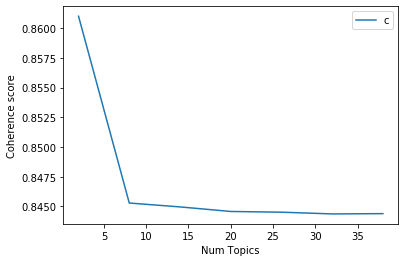

In [33]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()